지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 봤다!!

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시키는 프로젝트를 직접 해보게 된다. 데이터셋에 두 가지 방법을 적용하고, 모델을 학습시켜야 한다. 물론, 결과를 수치화하고 비교하는 작업도 해야 한다.

우선 주요 라이브러리 버전 확인~~



In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.8.2
1.21.6


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Augmentation을 적용한 데이터셋 만들기

이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 보기!

## (1) 데이터셋 불러오기
우선 기존에 사용했던 데이터셋을 가져오는 작업부터 시행!!!

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incomplete34IZFY/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incomplete34IZFY/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


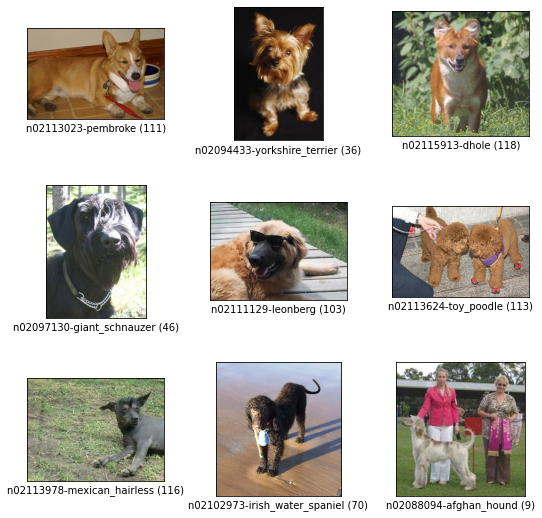

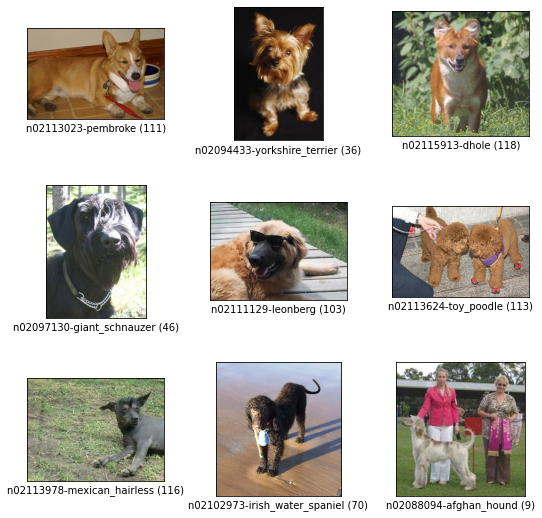

In [4]:
tfds.show_examples(ds_train, ds_info)

이미지 변환하는 전처리 함수의 형태를 기억하며 normalize, resize, augment 등 다양한 전처리 작업에 대한 함수를 직접 구현해 낸다.

```
def 전처리_함수(image, label):   # 변환할 이미지와 라벨
    # 이미지 변환 로직 적용
    new_image = 이미지_변환(image)
    return new_image, label
```






In [5]:
# 정규화 및 리사이즈에 대한 함수
def normalize_and_resize_img(image, label):
  # Normalizes images : `uint8` -> `float32`
  image = tf.image.resize(image, [224, 224])
  return tf.cast(image, tf.float32) / 255., label

Augmentation을 할 때 고려한 점으로는 다음과 같다.

* 이미지 분류 문제에서 개 이미지는 좌우를 대칭하더라도 문제가 생기지 않는다. 따라서 좌우대칭의 적용을 통해 데이터를 늘릴 수 있도록 해야 한다. 여기서 상하 대칭은 테스트 데이터셋의 이미지를 생각해 볼 때 위아래가 뒤집힌 사진이 없으므로 도움이 되지 않을 것이라 적용하지 않는다.

*  "brightness"를 조절하여 다양한 환경에서 얻어진 이미지에 대응할 수 있도록 한다.

In [6]:
# 적용시키고자 하는 Augmentation 기법 정의하는 함수
# 좌우 대칭 및 밝기 조절 구현
def augment(image, label):
  image = tf.image.random_flip_left_right(image)   
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
  ds=ds.map(
      normalize_and_resize_img,
      num_parallel_calls=2
  )
  if not is_test and with_aug:
    ds = ds.map(
        augment,
        num_parallel_calls=2
    )
  ds = ds.batch(batch_size)

  if not is_test:
    ds = ds.repeat()
    ds = ds.shuffle(200)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

  return ds

In [8]:
# augmentation이 적용된 데이터셋과 적용 안 된 데이터셋에 대한 변수를 지정해 둔다.
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train,with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## (2) CutMix 함수 적용해 이미지 섞기

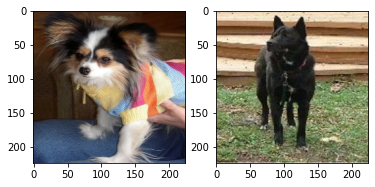

In [9]:
# 데이터셋에서 이미지 2개를 가져온다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

`image_a`(왼쪽 이미지)에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 구현한다.

In [10]:
def get_clip_box(image_a, image_b):
  # image.shape = (height, width, channel)
  image_size_x = image_a.shape[1]
  image_size_y = image_a.shape[0]

  # get center of box
  x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
  y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

  # get width, height of box
  width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
  height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

  # clip box in image and get minmax bbox
  x_min = tf.math.maximum(0, x-width//2)
  y_min = tf.math.maximum(0, y-height//2)
  x_max = tf.math.minimum(image_size_x, x+width//2)
  y_max = tf.math.minimum(image_size_y, y+width//2)

  return x_min, y_min, x_max, y_max

In [11]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(38, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(113, shape=(), dtype=int32)


바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현하는 과정!!

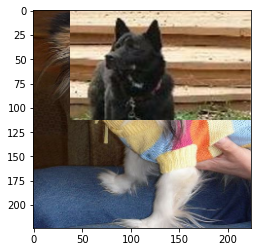

In [12]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
  image_size_x = image_a.shape[1]
  image_size_y = image_a.shape[0]
  middle_left = image_a[y_min:y_max, 0:x_min, :]    # image_b의 왼쪽 바깥 영역
  middle_center = image_b[y_min:y_max, x_min:x_max, :]   # image_b의 안쪽 영역
  middle_right = image_a[y_min:y_max, x_max:image_size_x, :]   # image_b의 오른쪽 바깥 영역
  middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
  top = image_a[0:y_min, :, :]
  bottom = image_a[y_max:image_size_y, :, :]
  mixed_img = tf.concat([top, middle, bottom], axis=0)

  return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

## (3) CutMix 함수 적용해 라벨 섞기

이미지를 섞었다면 라벨도 이에 맞게 섞어 줘야 한다. 그림에서 볼 수 있듯이, 우리가 강아지와 고양이의 이미지를 섞었다면 라벨 또한 적절한 비율로 섞어야 함을 알 수 있다.

In [13]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
  image_size_x = image_a.shape[1]
  image_size_y = image_a.shape[0]
  mixed_area = (x_max - x_min)*(y_max - y_min)
  total_area = image_size_x*image_size_y
  ratio = tf.cast(mixed_area/total_area, tf.float32)

  if len(label_a.shape)==0:
    label_a = tf.one_hot(label_a, num_classes)
  if len(label_b.shape)==0:
    label_b = tf.one_hot(label_b, num_classes)
  mixed_label = (1-ratio)*label_a + ratio*label_b
  return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.5811145 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

이제는 위에서 구현했던 두 함수 `mix_2_images()`와 `mix_2_label()`을 활용해서 배치 단위의 `cutmix()` 함수를 구현한다.

In [14]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
  mixed_imgs = []
  mixed_labels = []

  for i in range(batch_size):
    image_a = image[i]
    label_a = label[i]
    j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
    image_b = image[j]
    label_b = label[j]
    x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
    mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
    mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

  mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
  mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
  return mixed_imgs, mixed_labels

## (4) Mixup 함수 구현

Mixup의 경우는 CutMix에 비해 비교적 간단한 방법으로 이미지와 라벨을 섞어준다.

두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 된다.

In [15]:
num_classes = ds_info.features["label"].num_classes

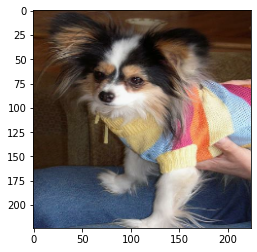

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.9705528
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.0294472 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0

In [16]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [17]:
#mixup 함수구현
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## (5) CutMix, Mixup - 수정된 데이터셋 재구현

> CutMix는 `batch()` 함수 뒤에 와야만 한다!! CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬한 후 CutMix가 적용되어야 한다.

In [18]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix: #cutmix
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    elif not is_test and with_mixup: # mixup
        ds = ds.map(mixup, num_parallel_calls=2)

    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

# 2. 모델 만들기

앞서 만들었던 것처럼 비교 실험을 위한 모델을 만들어야 한다.

비교를 하기 위해 두 가지 모델을 만든다.
1. ResNet50 with normal data
2. ResNet50 with augmented data
3. ResNet50 with cutmix data
4. ResNet50 with mixup data

## (1) 데이터 준비

1. ds_train_normal
2. ds_train_aug
3. ds_train_cutmix
4. ds_train_mixup, ds_test

In [19]:
# 하이퍼파라미터 지정
from tensorflow.keras.callbacks import EarlyStopping

lr = 0.005
batch_size = 16

es_3 = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
es_5 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
es = es_5

steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size)
validation_steps=int(ds_info.splits['test'].num_examples/batch_size)
epochs=20

In [20]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_normal = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=False,
    with_cutmix=False,
    with_mixup=False
)
ds_train_aug = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_cutmix=False,
    with_mixup=False
)
ds_train_cutmix = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=False,
    with_cutmix=True,
    with_mixup=False
)
ds_train_all_1 = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_cutmix=True,
    with_mixup=False
)
ds_train_mixup = apply_normalize_on_dataset(
    ds_train,
    batch_size = batch_size,
    with_aug= False,
    with_cutmix=False,
    with_mixup=True   
)

ds_train_all_2 = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_cutmix=False,
    with_mixup=True
)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## (2) 모델의 학습

무작위로 seed를 선택해 사용하게끔 먼저 설정을 한다. 이에 대한 추가 설명은 해당 링크를 참고하면 된다.
* [tf.random.set_seed](https://junstar92.tistory.com/98https://)
* [tf.random.set_seed 영문](https://www.tensorflow.org/api_docs/python/tf/random/set_seed?hl=ko)

In [22]:
# global random seed를 설정해주는 함수
tf.random.set_seed(1994)

### 1) ResNet50, Normal data

In [46]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [24]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_normal = resnet50.fit(
    ds_train_normal,    # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 177s 207ms/step - loss: 2.7178 - accuracy: 0.3722 - val_loss: 3.4134 - val_accuracy: 0.2025
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 0.9813 - accuracy: 0.7517 - val_loss: 1.0844 - val_accuracy: 0.6820
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.4291 - accuracy: 0.9092 - val_loss: 0.9781 - val_accuracy: 0.7120
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 0.1702 - accuracy: 0.9814 - val_loss: 0.9742 - val_accuracy: 0.7146
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0766 - accuracy: 0.9972 - val_loss: 0.9680 - val_accuracy: 0.7200
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0698 - accuracy: 0.9966 - val_loss: 0.9796 - val_accuracy: 0.7165
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0363 - accuracy: 0.9994 - val_loss: 0.9932 - val_accura

In [25]:
del resnet50

### 2) ResNet50, Augmented data

In [26]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [27]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,   # augmentation 적용한 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 165s 208ms/step - loss: 2.7707 - accuracy: 0.3585 - val_loss: 2.9846 - val_accuracy: 0.2558
Epoch 2/20
750/750 [==============================] - 155s 206ms/step - loss: 1.1508 - accuracy: 0.6871 - val_loss: 1.2900 - val_accuracy: 0.6243
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.6870 - accuracy: 0.8173 - val_loss: 1.0065 - val_accuracy: 0.7079
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 0.4523 - accuracy: 0.8892 - val_loss: 0.9744 - val_accuracy: 0.7139
Epoch 5/20
750/750 [==============================] - 155s 206ms/step - loss: 0.2711 - accuracy: 0.9443 - val_loss: 0.9465 - val_accuracy: 0.7239
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 0.2277 - accuracy: 0.9548 - val_loss: 0.9416 - val_accuracy: 0.7221
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 0.1226 - accuracy: 0.9828 - val_loss: 0.9365 -

In [28]:
del aug_resnet50

### 3) ResNet50, CutMix data

In [29]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [30]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix,    # augmentation 적용X, cutmix가 적용된 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 169s 211ms/step - loss: 4.1472 - accuracy: 0.1528 - val_loss: 3.6921 - val_accuracy: 0.1554
Epoch 2/20
750/750 [==============================] - 157s 209ms/step - loss: 3.1809 - accuracy: 0.3799 - val_loss: 1.3472 - val_accuracy: 0.6315
Epoch 3/20
750/750 [==============================] - 158s 210ms/step - loss: 2.8553 - accuracy: 0.4692 - val_loss: 1.2086 - val_accuracy: 0.6685
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 2.6413 - accuracy: 0.5303 - val_loss: 1.1721 - val_accuracy: 0.6873
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 2.4712 - accuracy: 0.5968 - val_loss: 1.0665 - val_accuracy: 0.7053
Epoch 6/20
750/750 [==============================] - 157s 210ms/step - loss: 2.3491 - accuracy: 0.6335 - val_loss: 1.0400 - val_accuracy: 0.7112
Epoch 7/20
750/750 [==============================] - 157s 210ms/step - loss: 2.2648 - accuracy: 0.6660 - val_loss: 1.0456 -

In [31]:
del cutmix_resnet50

### 4) ResNet50 - Augmented, CutMix 모두 적용

In [32]:
all_resnet50_1 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [33]:
all_resnet50_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_all_1 = all_resnet50_1.fit(
    ds_train_all_1, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 168s 210ms/step - loss: 4.2389 - accuracy: 0.1318 - val_loss: 3.2593 - val_accuracy: 0.2208
Epoch 2/20
750/750 [==============================] - 157s 209ms/step - loss: 3.2651 - accuracy: 0.3541 - val_loss: 1.3847 - val_accuracy: 0.6126
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 2.9695 - accuracy: 0.4417 - val_loss: 1.2342 - val_accuracy: 0.6473
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 2.7741 - accuracy: 0.4938 - val_loss: 1.1829 - val_accuracy: 0.6796
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 2.6315 - accuracy: 0.5413 - val_loss: 1.1093 - val_accuracy: 0.6755
Epoch 6/20
750/750 [==============================] - 157s 210ms/step - loss: 2.5408 - accuracy: 0.5669 - val_loss: 1.0211 - val_accuracy: 0.7135
Epoch 7/20
750/750 [==============================] - 157s 210ms/step - loss: 2.4350 - accuracy: 0.6013 - val_loss: 1.0449 -

In [34]:
del all_resnet50_1

### 5) ResNet50, Mixup data

In [35]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [36]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup,    # augmentation 적용X, cutmix가 적용된 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 167s 210ms/step - loss: 4.0226 - accuracy: 0.1842 - val_loss: 4.0054 - val_accuracy: 0.1094
Epoch 2/20
750/750 [==============================] - 156s 208ms/step - loss: 3.0148 - accuracy: 0.4348 - val_loss: 1.4586 - val_accuracy: 0.5976
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 2.7104 - accuracy: 0.5467 - val_loss: 1.3028 - val_accuracy: 0.6399
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 2.5467 - accuracy: 0.6003 - val_loss: 1.2050 - val_accuracy: 0.6578
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 2.3962 - accuracy: 0.6643 - val_loss: 1.0868 - val_accuracy: 0.6974
Epoch 6/20
750/750 [==============================] - 157s 210ms/step - loss: 2.3154 - accuracy: 0.6910 - val_loss: 1.1030 - val_accuracy: 0.6961
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 2.2302 - accuracy: 0.7225 - val_loss: 1.0922 -

In [37]:
del mixup_resnet50

### 6) ResNet50 - Augmented, Mixup 모두 적용

In [38]:
all_resnet50_2 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [39]:
all_resnet50_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_all_2 = all_resnet50_2.fit(
    ds_train_all_2, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 169s 211ms/step - loss: 4.1012 - accuracy: 0.1632 - val_loss: 3.7706 - val_accuracy: 0.1537
Epoch 2/20
750/750 [==============================] - 156s 209ms/step - loss: 3.0837 - accuracy: 0.4105 - val_loss: 1.4115 - val_accuracy: 0.6074
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 2.8275 - accuracy: 0.4938 - val_loss: 1.2082 - val_accuracy: 0.6533
Epoch 4/20
750/750 [==============================] - 172s 230ms/step - loss: 2.6366 - accuracy: 0.5656 - val_loss: 1.2633 - val_accuracy: 0.6405
Epoch 5/20
750/750 [==============================] - 158s 210ms/step - loss: 2.5350 - accuracy: 0.6022 - val_loss: 1.1336 - val_accuracy: 0.6751
Epoch 6/20
750/750 [==============================] - 158s 210ms/step - loss: 2.4372 - accuracy: 0.6457 - val_loss: 1.0961 - val_accuracy: 0.6915
Epoch 7/20
750/750 [==============================] - 158s 211ms/step - loss: 2.3488 - accuracy: 0.6712 - val_loss: 1.1216 -

In [40]:
del all_resnet50_2

## 3) 결과 시각화

### 전체 비교

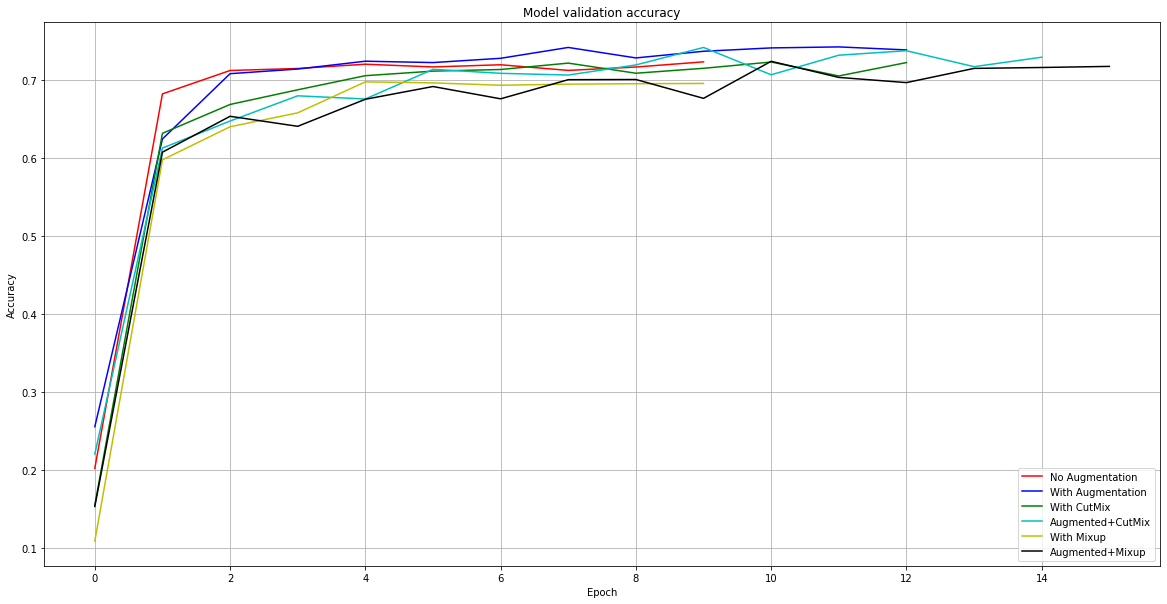

In [48]:
plt.figure(figsize=(20, 10))
plt.plot(history_resnet50_normal.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_all_1.history['val_accuracy'], 'c')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.plot(history_resnet50_all_2.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'Augmented+CutMix', 'With Mixup', 'Augmented+Mixup'], loc='best')
plt.grid(True)
plt.savefig('fig1_Accuracy.png')
plt.show()

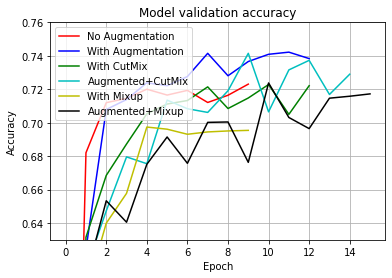

In [55]:
plt.plot(history_resnet50_normal.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_all_1.history['val_accuracy'], 'c')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.plot(history_resnet50_all_2.history['val_accuracy'], 'k')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'Augmented+CutMix', 'With Mixup', 'Augmented+Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.63, 0.76)
plt.show()

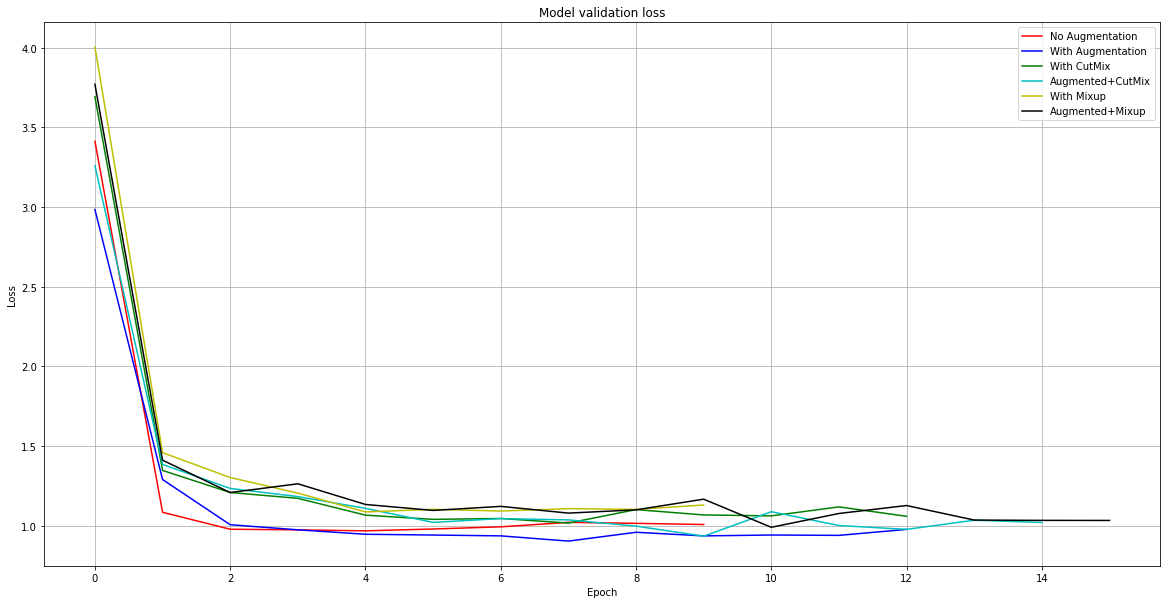

In [56]:
plt.figure(figsize=(20,10))
plt.plot(history_resnet50_normal.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_all_1.history['val_loss'], 'c')
plt.plot(history_resnet50_mixup.history['val_loss'], 'y')
plt.plot(history_resnet50_all_2.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'Augmented+CutMix', 'With Mixup', 'Augmented+Mixup'], loc='best')
plt.grid(True)
plt.grid(True)
plt.savefig('fig1_loss.png')
plt.show()

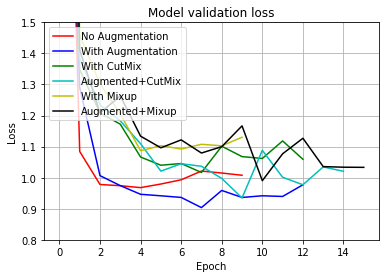

In [58]:
plt.plot(history_resnet50_normal.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_all_1.history['val_loss'], 'c')
plt.plot(history_resnet50_mixup.history['val_loss'], 'y')
plt.plot(history_resnet50_all_2.history['val_loss'], 'k')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'Augmented+CutMix', 'With Mixup', 'Augmented+Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.8, 1.5)
plt.show()

### No Augmentation VS With Augmentation

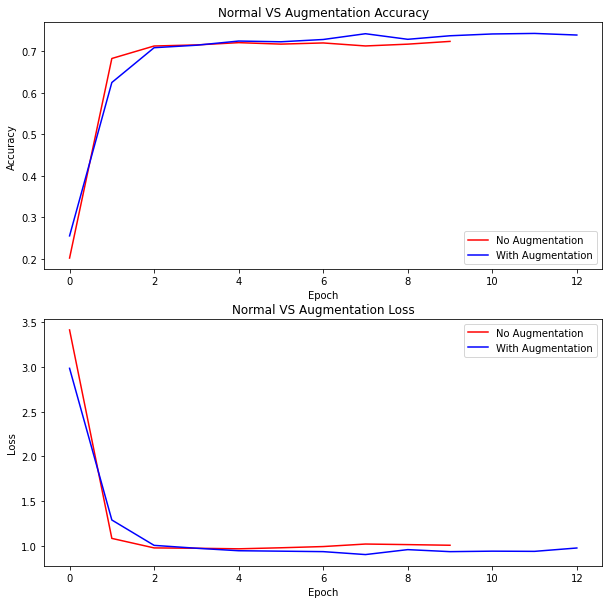

In [60]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history_resnet50_normal.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Normal VS Augmentation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='best')

plt.subplot(2, 1, 2)
plt.plot(history_resnet50_normal.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.title('Normal VS Augmentation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='best')

plt.show()

### CutMix VS Mixup

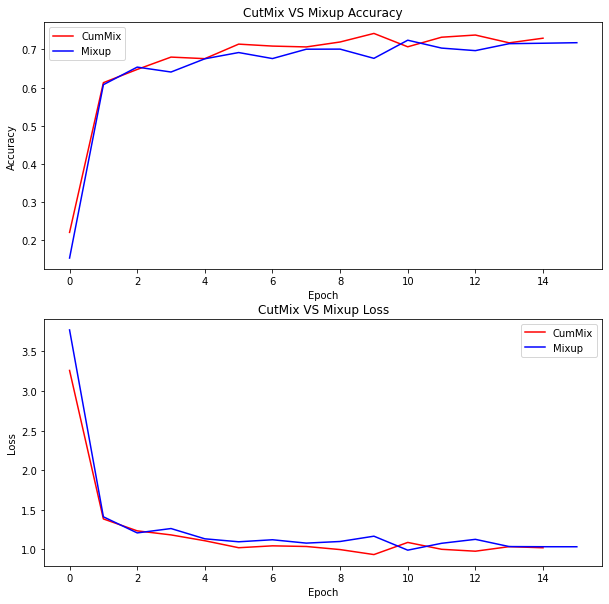

In [44]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history_resnet50_normal.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('CutMix VS Mixup Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CumMix', 'Mixup'], loc='best')

plt.subplot(2, 1, 2)
plt.plot(history_resnet50_all_1.history['val_loss'], 'r')
plt.plot(history_resnet50_all_2.history['val_loss'], 'b')
plt.title('CutMix VS Mixup Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['CumMix', 'Mixup'], loc='best')

plt.show()

In [45]:
print(f"Normal Data's best accuracy : {round(max(history_resnet50_normal.history['val_accuracy']), 3)}")
print(f"Augmented Data's best accuracy : {round(max(history_resnet50_aug.history['val_accuracy']), 3)}")
print(f"CutMix Data's best accuracy : {round(max(history_resnet50_cutmix.history['val_accuracy']), 3)}")
print(f"Augmentation & CutMix Data's best accuracy : {round(max(history_resnet50_all_1.history['val_accuracy']), 3)}")
print(f"Mixup Data's best accuracy : {round(max(history_resnet50_mixup.history['val_accuracy']), 3)}")
print(f"Augmentation & Mixup Data's best accuracy : {round(max(history_resnet50_all_2.history['val_accuracy']), 3)}")

Normal Data's best accuracy : 0.723
Augmented Data's best accuracy : 0.742
CutMix Data's best accuracy : 0.723
Augmentation & CutMix Data's best accuracy : 0.741
Mixup Data's best accuracy : 0.697
Augmentation & Mixup Data's best accuracy : 0.724


# ✍루브릭

|평가문항|상세기준|결과|
|------|------|:------:|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|O|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음|O|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|O|




# 결과 분석 및 회고

1. 최종적으로 정확도는 Augmentation과 Cutmix를 모두 적용한 5번 케이스에서 가장 높게 나온 걸 확인할 수 있다.

* Normal Data's best accuracy : 0.723  
* Augmented Data's best accuracy : 0.742  
* CutMix Data's best accuracy : 0.723  
* Augmentation & CutMix Data's best accuracy : 0.741  
* Mixup Data's best accuracy : 0.697  
* Augmentation & Mixup Data's best accuracy : 0.724 

2. Augmentation을 적용한 CutMix와 Mixup(각각 하늘색, 검은색 선)의 경우는 다른 경우에 비해 EPOCH를 길게 끌고 갔다. 그만큼 더 다양한 무작위 가중치로 학습을 해봄으로써, 적합한 파라미터를 찾을 확률이 올라가므로 손실 값이 내려가게 될 확률이 높다.

3. Augmentation을 적용한 것이 정확도 역시 개선되었음을 알 수 있다. 원래 Augmentation이라는 단어가 확대, 증가의 뜻을 가지는데 이제까지 배웠던 좌우 반전이라든지 center crop, 밝기 조절 등을 적용시킴으로서 원본 이미지에 다양한 변화를 입힌 데이터셋을 증대시키는 것이다. 즉 다양한 환경을 모델이 학습할 수 있는 것이기 때문에 Augmentation을 적용시킨 모델이 그렇지 않은 모델에 비해 정확도가 향상될 수 있는 것이다.

4. CutMix와 Mixup끼리 비교했을 땐 전반적으로 CutMix의 성능이 조금 더 우수한 것으로 밝혀졌다. CutMix가 하나의 이미지 안에 두 개의 레이블을 가진 이미지를 적당한 비율로 배치하여 두 개의 레이블이 하나의 이미지에 비율에 맞게 배치되게끔 하는 것이었고, Mixup처럼 두 개의 이미지를 완전히 혼합하여 새로운 이미지를 만드는 것이었다. 그런데 Mixup은 그냥 두 이미지의 투명도만 적절하게 랜덤으로 조절을 하다보니 인식을 함에 있어서 효율이 다소 떨어지는 측면이 없잖아 있는 거 같았고, 그렇다보니 CutMix로 했을 때 두 레이블을 이미지의 배치에 대해 더 잘 학습하여서 이러한 결과가 나오지 않았나 생각이 든다.

5. 이 때 사용했던 기법은 좌우 대칭 및 밝기 조절 뿐이었지만, 이 외에도 Center Crop이나 Saturation의 기법까지 응용해 봤으면 결과가 더 좋게 나오지 않았을까 하는 다소 아쉬운 생각이 들긴 했다. 하지만 최적의 기법이란 보편적으로 사용되고 해당 노드에서도 자주 언급이 되었던 좌우 대칭 및 밝기 조절이 아닐까? 생각하며 이번 노드도 무사히 마친다!!!!!!

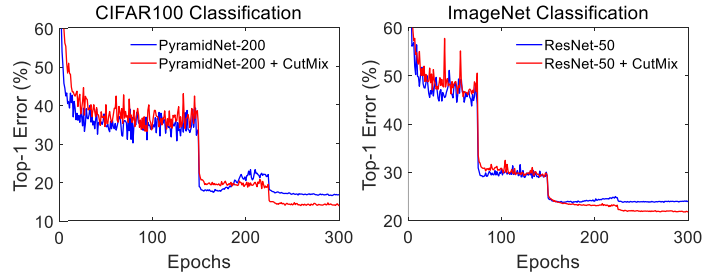

# Reference

* 선배 그루님의 프로젝트 : https://github.com/ljh415/AIFFEL/blob/master/Going_Deeper/02.Data_Augmentation_CutMix/data_augmentation_cutmix.ipynb

* 학습 단위에 대한 설명 : https://gooopy.tistory.com/68

* CutMix 정리해보기 : https://blog.naver.com/PostView.naver?blogId=jjunsss&logNo=222523739775

* CutMix와 Mixup의 비교실험 : https://github.com/stereo-weld/explorations/blob/master/CV4_Project_Augmentation_CutMix_MixUp_v2.ipynb